# Compute display LED intensities

In [1]:
import os
import re
import csv
import datetime
import numpy as np
import cv2
from PIL import Image
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
video_dir = 'videos'
frames_dir = 'video-frames'
image_dir = 'images'
data_dir = 'data'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

## Load fireplace video file and extract frames

In [3]:
filename = 'Fireplace 10 hours full HD.mp4'

vidcap = cv2.VideoCapture(os.path.join(video_dir, filename))
vidcap

<VideoCapture 0x12a69d5f0>

In [4]:
success, image = vidcap.read()
count = 0
print("Reading frames from video...")
while success and count < 1500:
    filename = f"frame{count:04d}.jpg"
    # save frame as JPEG file
    cv2.imwrite(os.path.join(frames_dir, filename), image)     
    success, image = vidcap.read()
    count += 1
print(f"{count} frame images saved to '{frames_dir}'.")

Reading frames from video...
1500 frame images saved to 'video-frames'.


## Load video frame images

In [5]:
filenames = sorted([name for name in os.listdir(frames_dir)
                    if name.startswith('frame')])
print(f"{len(filenames)} image files found")
filenames[:10]

1500 image files found


['frame0000.jpg',
 'frame0001.jpg',
 'frame0002.jpg',
 'frame0003.jpg',
 'frame0004.jpg',
 'frame0005.jpg',
 'frame0006.jpg',
 'frame0007.jpg',
 'frame0008.jpg',
 'frame0009.jpg']

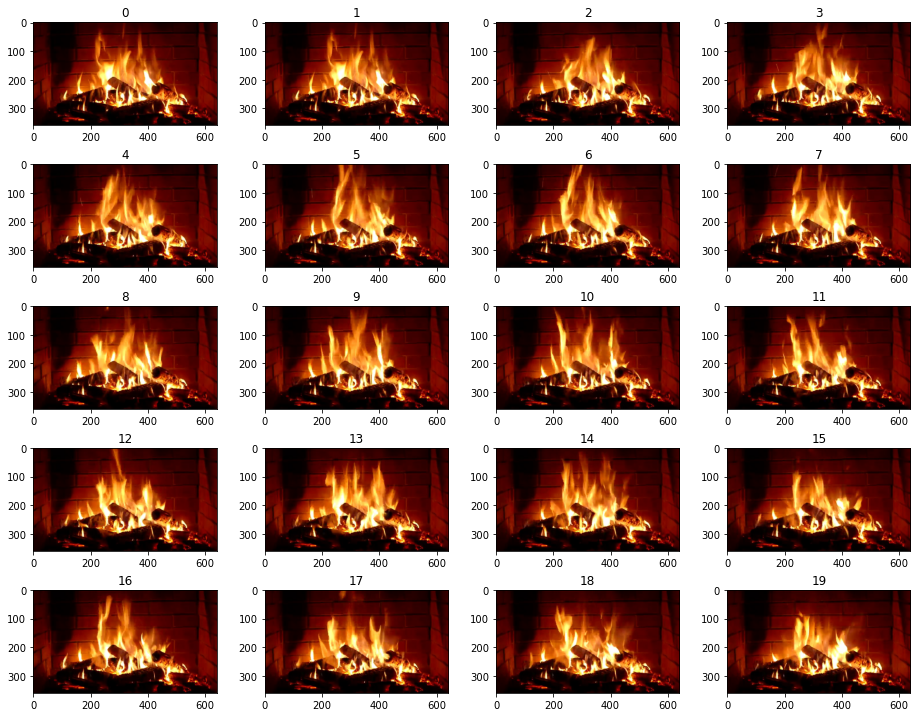

In [6]:
# Display selected images
selection = range(20)
fig, axes = plt.subplots(5, 4, figsize=(13, 10))
for i, img_id in enumerate(selection):
    ax = axes[i // 4, i % 4]
    img = Image.open(os.path.join(frames_dir, filenames[img_id]))
    ax.imshow(img)
    ax.set_title(img_id)
plt.tight_layout()
plt.show()

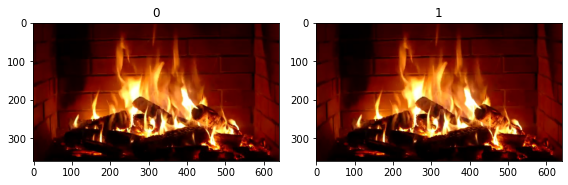

In [7]:
# Compare two frames
selection = [0, 1]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
for i, img_id in enumerate(selection):
    ax = axes[i]
    img = Image.open(os.path.join(frames_dir, filenames[img_id]))
    ax.imshow(img)
    ax.set_title(img_id)
plt.tight_layout()
plt.show()

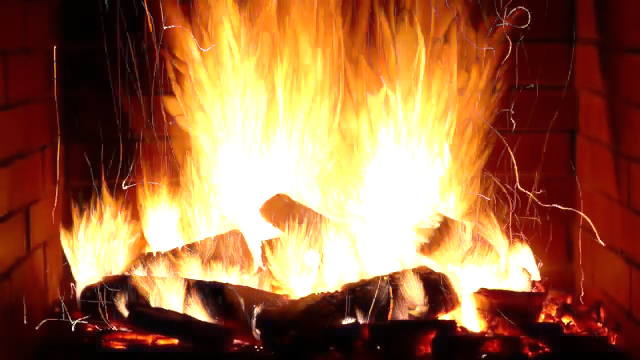

In [8]:
# Combine all frames into one image
img = Image.new('RGB', img.size)
img_data = np.array(img)
for filename in filenames:
    img = Image.open(os.path.join(frames_dir, filename))
    img_data = np.maximum(img_data, np.array(img))
combined_images = Image.fromarray(img_data)
combined_images.save(os.path.join(image_dir, f"combined_{len(filenames)}.jpg"))
combined_images

In [9]:
# Load mask images
images = []
size = None
for i in range(86):
    filename = f"im_{i:03d}.png"
    im = Image.open(os.path.join(image_dir, filename))
    if size is not None:
        assert(im.size == size)
    images.append(im)


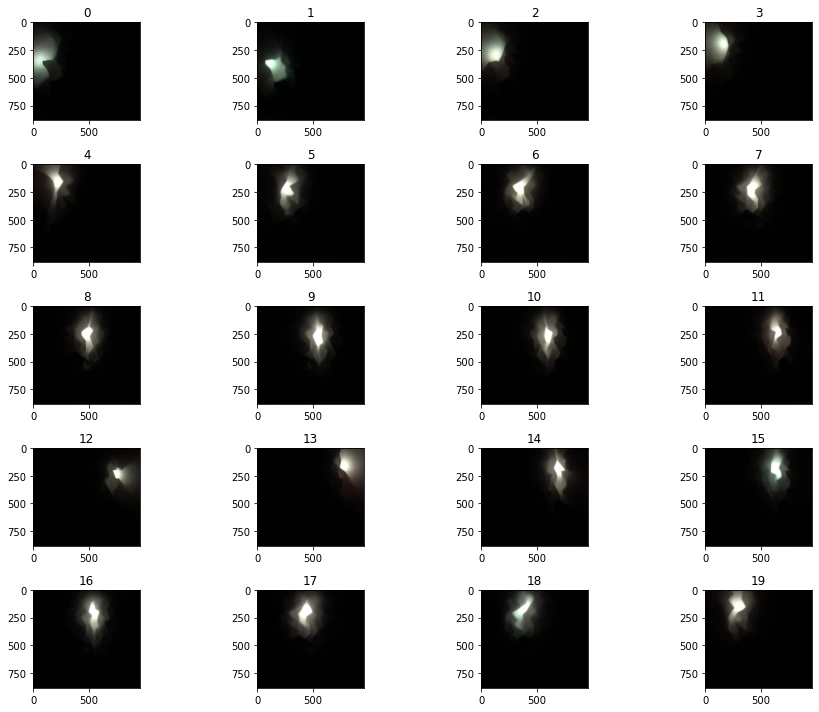

In [10]:
# Display selected mask images
selection = range(20)
fig, axes = plt.subplots(5, 4, figsize=(13, 10))
for i, img_id in enumerate(selection):
    ax = axes[i // 4, i % 4]
    img = images[img_id]
    ax.imshow(img)
    ax.set_title(img_id)
plt.tight_layout()
plt.show()

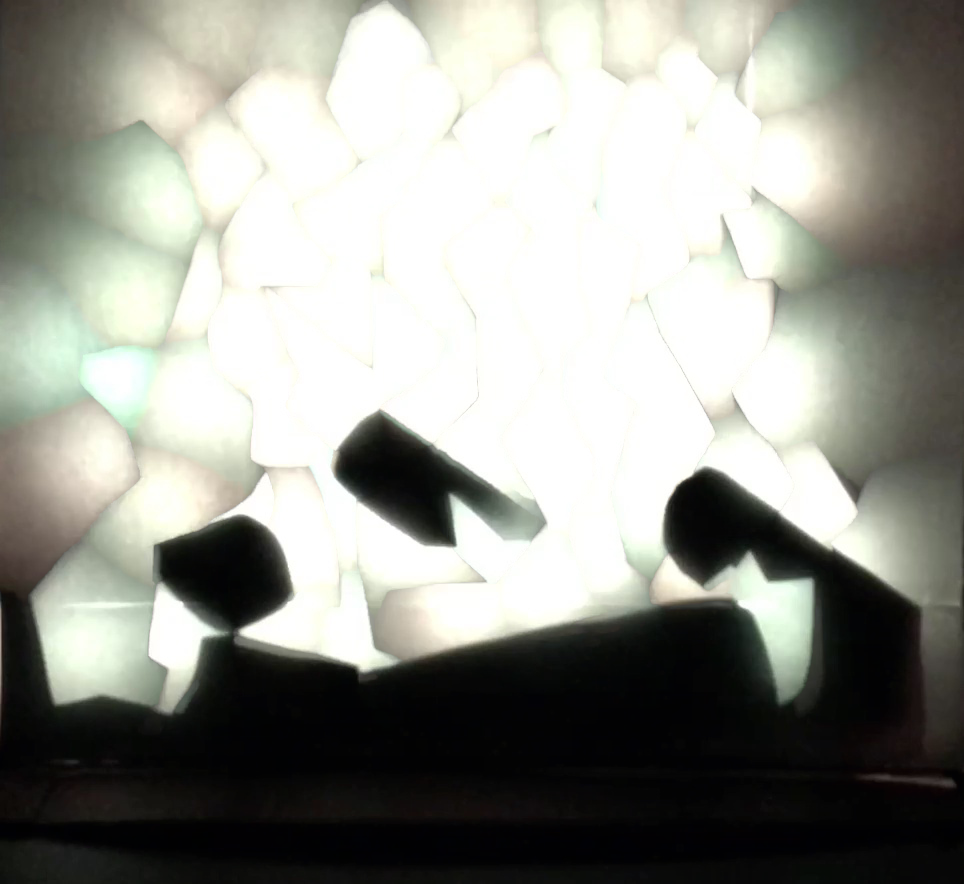

In [11]:
all_masks = Image.open(os.path.join(image_dir, "all_masks_86.png"))
all_masks

## Adjust mask images to match video frames

In [12]:
combined_images.size, all_masks.size

((640, 360), (964, 884))

(430, 347) (430, 347)


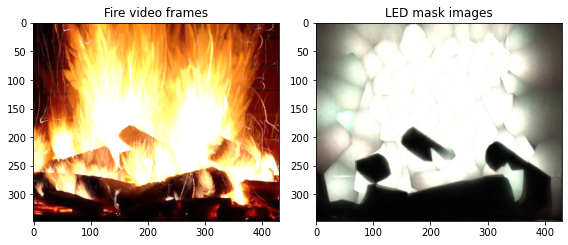

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

img_crop = [110, 13, 540, 360]
mask_crop = [0, 0, 964, 780]

combined_fire_adj = combined_images.crop(img_crop)
all_masks_adj = all_masks.crop(mask_crop)
mask_scale = combined_fire_adj.size[0] / all_masks_adj.size[0]
mask_resize = (np.array(all_masks_adj.size)*mask_scale).astype(int)
all_masks_adj = all_masks_adj.resize(mask_resize)
print(combined_fire_adj.size, all_masks_adj.size)

ax = axes[0]
ax.imshow(combined_fire_adj)
ax.set_title('Fire video frames')

ax = axes[1]
ax.imshow(all_masks_adj)
ax.set_title('LED mask images')

plt.tight_layout()
plt.savefig(os.path.join(image_dir, 'fig_combined_images.png'))
plt.show()

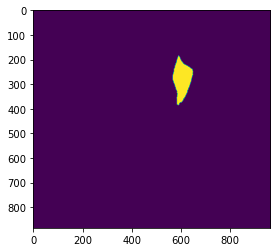

In [14]:
def im_mask(im, thresh=160):
    return (np.array(im) > thresh)[:, :, 0]

plt.imshow(im_mask(images[10]))
plt.show()

## Resize all mask images

In [15]:
# Save images
images = []
image_masks = []
for i in range(86):
    img = Image.open(os.path.join(image_dir, f"im_{i:03d}.png"))
    img_adj = img.crop(mask_crop).resize(mask_resize)
    img_adj.save(os.path.join(image_dir, f"im_{i:03d}_adj.png"))
    images.append(img_adj)
    image_masks.append(im_mask(img_adj))

## View individual masks

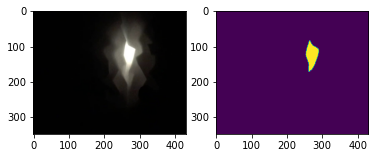

In [16]:
i = 10
img = images[i]
img_mask = Image.fromarray((image_masks[i]*255).astype('uint8'))

plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_mask)
plt.show()

## Compute LED intensities to mimic video frame

(430, 347)


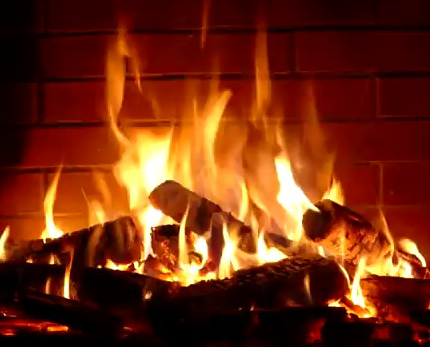

In [17]:
# Select a video frame (Note: 1st two frames are identical for some reason)
filename = filenames[1]
fire_img = Image.open(os.path.join(frames_dir, filename)).crop(img_crop)
print(fire_img.size)
fire_img

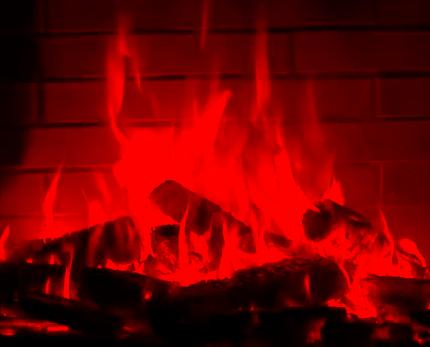

In [18]:
# RGB colours
fire_img_data = np.array(fire_img)
fire_img_data[:, :, 1] = 0
fire_img_data[:, :, 2] = 0
Image.fromarray(fire_img_data)

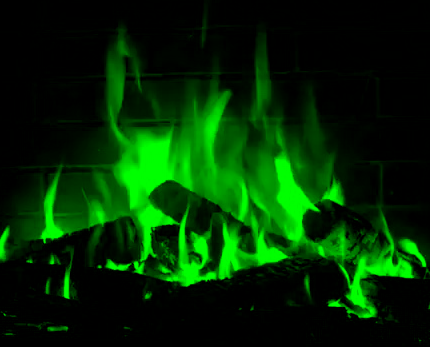

In [19]:
fire_img_data = np.array(fire_img)
fire_img_data[:, :, 0] = 0
fire_img_data[:, :, 2] = 0
Image.fromarray(fire_img_data)

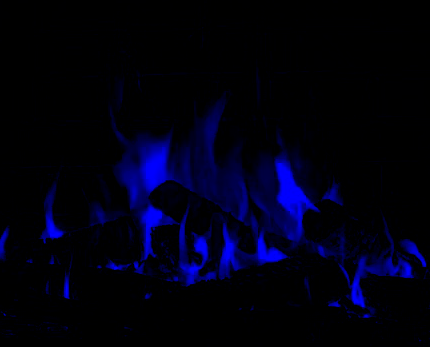

In [20]:
fire_img_data = np.array(fire_img)
fire_img_data[:, :, 0] = 0
fire_img_data[:, :, 1] = 0
Image.fromarray(fire_img_data)

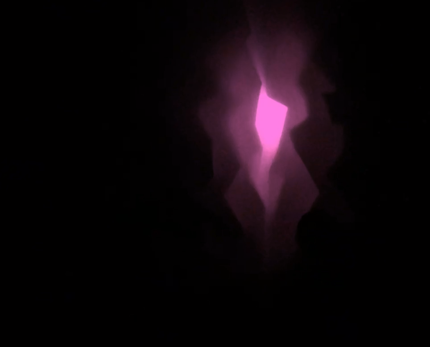

In [21]:
def filter_img_data(img_data, rgb):
    """Linearly adjust image intensities according to the
    rgb adjustment factors.
    """
    return np.clip(img_data.astype('float32') \
                   * np.array(rgb), 0, 255).astype('uint8')

mask_id = 10
mask_img_data = np.array(images[mask_id])

# RGB adjustment factors
rgb = [1, 0.5, 0.9]
                         
img_data_adj = filter_img_data(mask_img_data, rgb)
Image.fromarray(img_data_adj)

In [22]:
# Check masks and video frame images are same shape
fire_img_data.shape, mask_img_data.shape

((347, 430, 3), (347, 430, 3))

## Experiment 1 - compare one mask at a time

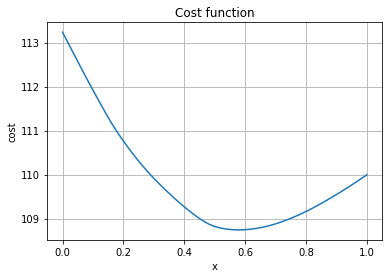

In [23]:
mask_id = 2
c = 0  # colour channel (r, g, b)
mask_img_data_c = np.array(images[mask_id])[:, :, c].astype('float32')

fire_img_data = np.array(fire_img)
fire_img_data_c = fire_img_data[:, :, c].astype('float32')

def cost_function(x):
    mask_img_data_adj = np.clip(mask_img_data_c * x, 0, 255)
    diff = np.abs(fire_img_data_c - mask_img_data_adj)
    return np.mean(diff)

x_values = np.linspace(0, 1, 51)
costs = []
for x in x_values:
    costs.append(cost_function(x))
plt.plot(x_values, costs)
plt.xlabel('x')
plt.ylabel('cost')
plt.title('Cost function')
plt.grid()
plt.show()

In [24]:
x0 = 1
res = minimize(cost_function, x0, bounds=[(0, 1)],
               options={'gtol': 1e-6})
print(res.message)
assert(res.status == 0)
x = res.x[0]
x

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


0.5789473698329792

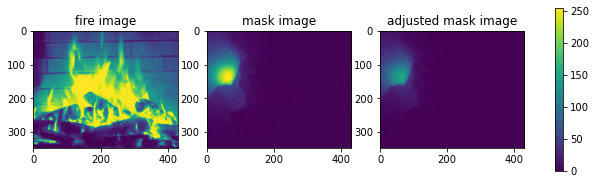

In [25]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

bool_mask = image_masks[mask_id]

img_data = np.zeros(bool_mask.shape)
img_data[bool_mask] = fire_img_data_c[bool_mask]
img1 = Image.fromarray(fire_img_data_c.astype('uint8'))

img2 = Image.fromarray(mask_img_data_c.astype('uint8'))

img3 = Image.fromarray(np.clip(mask_img_data_c * x, 0, 255).astype('uint8'))

fig, axes = plt.subplots(1, 3, figsize=(11, 3))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(0, 255)
im = cm.ScalarMappable(norm=normalizer)
ax = axes[0]
ax.imshow(img1, vmin=0, vmax=255, cmap=cmap)
ax.set_title('fire image')
ax = axes[1]
ax.imshow(img2, vmin=0, vmax=255, cmap=cmap)
ax.set_title('mask image')
ax = axes[2]
ax.imshow(img3, vmin=0, vmax=255, cmap=cmap)
ax.set_title('adjusted mask image')
fig.colorbar(im, ax=axes.ravel().tolist())
plt.savefig(os.path.join(image_dir, 'fig_image_mask_opt.png'))
plt.show()

## Calculate all led intensities simultaneously

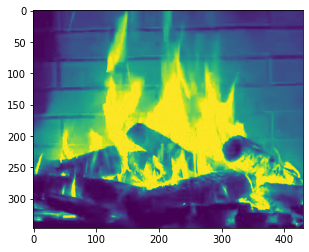

In [26]:
filename = filenames[7]
fire_img = Image.open(os.path.join(frames_dir, filename)).crop(img_crop)
fire_img_data = np.array(fire_img)

c = 0  # colour channel (r, g, b)
fire_img_data_c = fire_img_data[:, :, c]

plt.imshow(fire_img_data_c)
plt.show()

Cost function

$$J(x) = (A - B_1x_1 - B_2x_2 - ... - B_nx_n)^2$$

In [27]:
img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])
img_mask_array.shape

(86, 347, 430)

In [28]:
img_mask_array.max()

255.0

In [29]:
img_mask_array.dtype

dtype('float64')

In [30]:
x = np.zeros(86)
x[-1] = 1
x.shape

(86,)

In [31]:
(x.reshape(-1, 1, 1) * img_mask_array).shape

(86, 347, 430)

In [32]:
combined_mask_data = (x.reshape(-1, 1, 1) * img_mask_array).max(axis=0)
combined_mask_data.shape

(347, 430)

In [33]:
combined_mask_data.max()

255.0

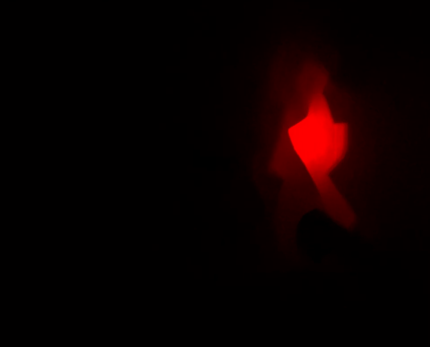

In [34]:
combined_img_data_uint8 = np.stack([
    np.clip(combined_mask_data, 0, 255), 
    np.zeros((347, 430)), 
    np.zeros((347, 430))
], axis=2).astype('uint8')

Image.fromarray(combined_img_data_uint8)

In [35]:
combined_mask_data.shape

(347, 430)

In [36]:
diff = (fire_img_data_c - combined_mask_data) ** 2
diff

array([[  1.,   1.,   9., ..., 900., 900., 900.],
       [  1.,   1.,   9., ..., 900., 900., 900.],
       [  1.,   1.,   9., ..., 900., 900., 900.],
       ...,
       [  1.,   1.,   1., ...,   4.,   1.,  36.],
       [  1.,   1.,   1., ...,   1.,   1.,  36.],
       [  1.,   1.,   1., ...,   1.,   9.,  36.]])

In [37]:
def cost_function(x):
    combined_mask_data = (x.reshape(-1, 1, 1) * img_mask_array).max(axis=0)
    diff = (fire_img_data_c - combined_mask_data) ** 2
    return np.mean(diff)

x = np.random.rand(86)
cost_function(x)

7956.619309619477

In [38]:
%timeit cost_function(x)

75.7 ms ± 4.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
# Solve using optimizer
x0 = np.random.rand(86)
res = minimize(cost_function, x0, method='Powell', 
               bounds=[(0, 1)]*86, tol=0.1)
print(res.message)
assert(res.status == 0)
x = res.x
x

Optimization terminated successfully.


array([0.06470554, 0.52786405, 0.38196601, 0.330106  , 0.32240727,
       0.76393202, 0.27568366, 0.5604627 , 0.90983006, 0.67376208,
       0.70820393, 0.70679706, 0.41529935, 0.34788858, 0.38196601,
       0.52786405, 0.58470066, 0.27568366, 0.43880262, 0.27568366,
       0.65136732, 0.23606798, 0.2744881 , 0.29618732, 0.38196601,
       0.30427652, 0.34021328, 0.53136873, 0.43880262, 0.06470554,
       0.2975422 , 0.20273464, 0.03553535, 0.20273464, 0.06470554,
       0.34033053, 0.42918385, 0.06470554, 0.20273464, 0.23606798,
       0.16940131, 0.07223286, 0.06470554, 0.33829875, 0.82076863,
       0.71005081, 0.85410197, 0.65136732, 0.94316339, 0.94427191,
       0.5544863 , 0.51794534, 0.94427191, 0.27568365, 0.79726536,
       0.81965067, 0.94316339, 0.65136732, 0.61803399, 0.79726536,
       0.85854425, 0.73059869, 0.94427191, 0.67376208, 0.61803399,
       0.82076863, 0.94316339, 0.94427191, 0.94427191, 0.65136732,
       0.72174103, 0.94427191, 0.33934579, 0.94427191, 0.94427

In [40]:
def construct_image_rgb(rgb, img_mask_array):
    rgb = np.clip(rgb, 0, 255)
    img_data = []
    for i in range(3):
        combined_mask_data = (rgb[:, i].reshape(-1, 1, 1) * img_mask_array).max(axis=0)
        img_data.append(combined_mask_data)
    combined_img_data_uint8 = np.stack(img_data, axis=2).astype('uint8')
    return Image.fromarray(combined_img_data_uint8)


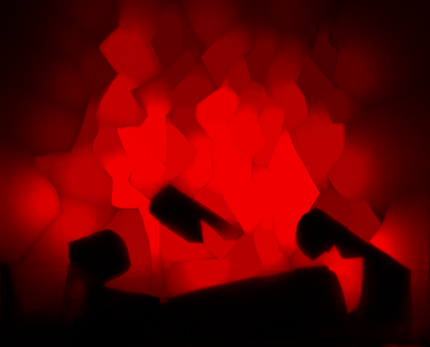

In [41]:
n = len(x)
rgb = np.zeros((n, 3))
rgb[:, 0] = x

construct_image_rgb(rgb, img_mask_array)

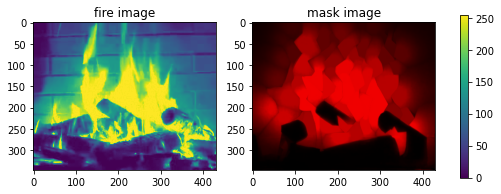

In [42]:
combined_mask_data = (x.reshape(-1, 1, 1) * img_mask_array).max(axis=0)
combined_img_data_uint8 = np.stack([
    np.clip(combined_mask_data, 0, 255), 
    np.zeros((347, 430)), 
    np.zeros((347, 430))
], axis=2).astype('uint8')

img = Image.fromarray(combined_img_data_uint8)

fig, axes = plt.subplots(1, 2, figsize=(9, 3))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(0, 255)
im = cm.ScalarMappable(norm=normalizer)
ax = axes[0]
ax.imshow(fire_img_data_c, vmin=0, vmax=255, cmap=cmap)
ax.set_title('fire image')
ax = axes[1]
ax.imshow(img, vmin=0, vmax=255, cmap=cmap)
ax.set_title('mask image')

fig.colorbar(im, ax=axes.ravel().tolist())
plt.savefig(os.path.join(image_dir, 'fig_image_mask_opt_r.png'))
plt.show()


In [43]:
def solve_mask_intensity_c1(target_image, img_mask_array, x0=None,
                            method='Powell', options=None):
    n = img_mask_array.shape[0]
    if x0 is None:
        x0 = 0.5*np.ones(n)

    def cost_function(x):
        combined_mask_data = (
            x.reshape(-1, 1, 1) * img_mask_array
        ).max(axis=0)
        diff = (target_image - combined_mask_data) ** 2
        return np.mean(diff)
    
    res = minimize(cost_function, x0, method=method, 
                   bounds=[(0, 1)]*86, tol=0.1, options=options)
    print(res.message)
    return res

# Example:
#x = solve_mask_intensity_c1(fire_img_data_c, img_mask_array, x0=x0,
#                            method='Powell', disp=True)

In [44]:
# Use previous solution as starting point
x0 = [ 0.06470554, 0.52786405, 0.38196601, 0.3291854 , 0.33083793,
       0.34234966, 0.57050849, 0.55836709, 0.8874353 , 0.67376208,
       0.70820393, 0.70664089, 0.41529935, 0.3480859 , 0.38196601,
       0.52786405, 0.53855738, 0.47213595, 0.47213595, 0.7169832 ,
       0.58207086, 0.23606798, 0.27544719, 0.06470554, 0.38196601,
       0.06470554, 0.23606798, 0.56695038, 0.43880262, 0.06470554,
       0.30218964, 0.20273464, 0.03802909, 0.23606798, 0.28663972,
       0.34195069, 0.42953714, 0.06470554, 0.20273464, 0.23606798,
       0.16940131, 0.03967538, 0.06470554, 0.3379184 , 0.85410197,
       0.70040974, 0.85410197, 0.65136733, 0.94316339, 0.94427191,
       0.55465419, 0.51972095, 0.94427191, 0.27568366, 0.79726536,
       0.81387248, 0.94316339, 0.65136732, 0.57772345, 0.79726536,
       0.85975178, 0.73059869, 0.94427191, 0.67376208, 0.61803399,
       0.82076863, 0.94316339, 0.94427191, 0.94427191, 0.65136732,
       0.72164121, 0.94427191, 0.33934579, 0.94427191, 0.94427191,
       0.85410197, 0.94427191, 0.71574452, 0.49398591, 0.69726535,
       0.93037568, 0.61803399, 0.94427191, 0.90983006, 0.85410197,
       0.67376208]

In [ ]:
%%time

c = 0  # red
fire_img_data_c = fire_img_data[:, :, c]
img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])

options = {'xtol': 0.01, 'disp': True, 'return_all': True}
res = solve_mask_intensity_c1(fire_img_data_c, img_mask_array, x0=x0,
                            method='Powell', options=options)

print(res.x)
assert(res.status == 0)

r = res.x
r

In [45]:
%%time

c = 1  # green
fire_img_data_c = fire_img_data[:, :, c]
img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])

options = {'xtol': 0.01, 'disp': True, 'return_all': True}
res = solve_mask_intensity_c1(fire_img_data_c, img_mask_array, x0=x,
                            method='Powell', options=options)

g = res.x
g

Optimization terminated successfully.
         Current function value: 2110.850909
         Iterations: 2
         Function evaluations: 1725
Optimization terminated successfully.
[0.06470554 0.52786405 0.38196601 0.330106   0.32240727 0.76393202
 0.27568366 0.5604627  0.90983006 0.67376208 0.70820393 0.70679706
 0.41529935 0.34788858 0.38196601 0.52786405 0.58470066 0.27568366
 0.43880262 0.27568366 0.65136732 0.23606798 0.2744881  0.29618732
 0.38196601 0.30427652 0.34021328 0.53136873 0.43880262 0.06470554
 0.2975422  0.20273464 0.03553535 0.20273464 0.06470554 0.34033053
 0.42918385 0.06470554 0.20273464 0.23606798 0.16940131 0.07223286
 0.06470554 0.33829875 0.82076863 0.71005081 0.85410197 0.65136732
 0.94316339 0.94427191 0.5544863  0.51794534 0.94427191 0.27568365
 0.79726536 0.81965067 0.94316339 0.65136732 0.61803399 0.79726536
 0.85854425 0.73059869 0.94427191 0.67376208 0.61803399 0.82076863
 0.94316339 0.94427191 0.94427191 0.65136732 0.72174103 0.94427191
 0.33934579 0.94

In [ ]:
n = len(x)
rgb = np.zeros((n, 3))
rgb[:, 1] = g

construct_image_rgb(rgb, img_mask_array)

In [47]:
%%time

c = 2  # blue
fire_img_data_c = fire_img_data[:, :, c]
img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])

options = {'xtol': 0.01, 'disp': True, 'return_all': True}
res = solve_mask_intensity_c1(fire_img_data_c, img_mask_array, x0=x0,
                            method='Powell', options=options)

print(res.x)
assert(res.status == 0)

b = res.x
b

Optimization terminated successfully.
         Current function value: 1125.318561
         Iterations: 3
         Function evaluations: 2683
Optimization terminated successfully.
[0.00373083 0.00587196 0.00505062 0.00648895 0.00559094 0.00567051
 0.0054933  0.00574698 0.07386976 0.00540747 0.06476643 0.05309929
 0.00483081 0.00442884 0.004202   0.03279542 0.07090652 0.00657644
 0.00555    0.0042212  0.00962619 0.00438469 0.00658918 0.00759633
 0.00432253 0.0042024  0.00586445 0.00620631 0.0047355  0.00650684
 0.00612206 0.00442884 0.00442884 0.00452119 0.00346032 0.00634421
 0.00545841 0.0057579  0.00629942 0.00537217 0.0554981  0.00632202
 0.0340621  0.0868986  0.35586033 0.27617598 0.64198864 0.05639226
 0.2786677  0.14699913 0.01126837 0.05700271 0.31943584 0.2971421
 0.23940131 0.18561569 0.42186053 0.12493062 0.00603783 0.14101592
 0.07491752 0.00464549 0.31051137 0.13832159 0.26920939 0.12525334
 0.12694545 0.10812071 0.5604584  0.00515904 0.03584381 0.07569446
 0.10403708 0.291

array([0.00373083, 0.00587196, 0.00505062, 0.00648895, 0.00559094,
       0.00567051, 0.0054933 , 0.00574698, 0.07386976, 0.00540747,
       0.06476643, 0.05309929, 0.00483081, 0.00442884, 0.004202  ,
       0.03279542, 0.07090652, 0.00657644, 0.00555   , 0.0042212 ,
       0.00962619, 0.00438469, 0.00658918, 0.00759633, 0.00432253,
       0.0042024 , 0.00586445, 0.00620631, 0.0047355 , 0.00650684,
       0.00612206, 0.00442884, 0.00442884, 0.00452119, 0.00346032,
       0.00634421, 0.00545841, 0.0057579 , 0.00629942, 0.00537217,
       0.0554981 , 0.00632202, 0.0340621 , 0.0868986 , 0.35586033,
       0.27617598, 0.64198864, 0.05639226, 0.2786677 , 0.14699913,
       0.01126837, 0.05700271, 0.31943584, 0.2971421 , 0.23940131,
       0.18561569, 0.42186053, 0.12493062, 0.00603783, 0.14101592,
       0.07491752, 0.00464549, 0.31051137, 0.13832159, 0.26920939,
       0.12525334, 0.12694545, 0.10812071, 0.5604584 , 0.00515904,
       0.03584381, 0.07569446, 0.10403708, 0.29102165, 0.00342

In [48]:
# Cost function each iteration
for x in res.allvecs:
    print(cost_function(x))

11167.138324693868
1864.8699862253118
1185.3494821791203
1125.318560770701


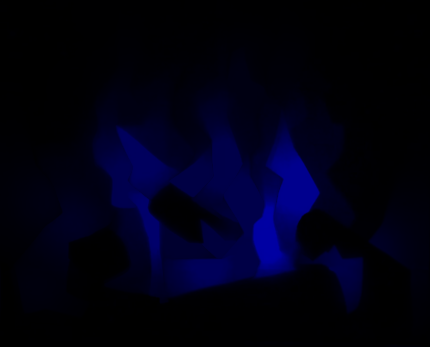

In [49]:
n = len(x)
rgb = np.zeros((n, 3))
rgb[:, 2] = b

construct_image_rgb(rgb, img_mask_array)

## Show RGB LED intensities

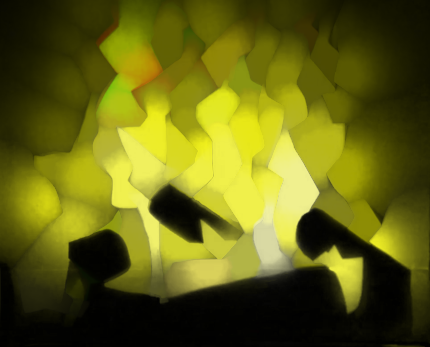

In [51]:
rgb = np.vstack([r, g, b]).T
img = construct_image_rgb(rgb, img_mask_array)
img.save(os.path.join(image_dir, 'reconstructed_image.png'))
img

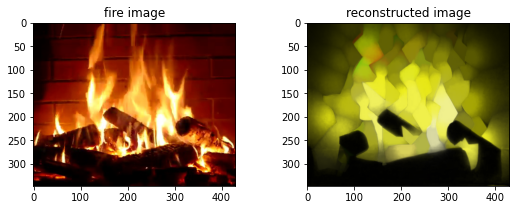

In [52]:
img = construct_image_rgb(rgb, img_mask_array)

fig, axes = plt.subplots(1, 2, figsize=(9, 3))

ax = axes[0]
ax.imshow(fire_img_data)
ax.set_title('fire image')
ax = axes[1]
ax.imshow(img)
ax.set_title('reconstructed image')

plt.savefig(os.path.join(image_dir, 'fig_image_mask_opt.png'))
plt.show()

## Automated calculation of sequence of frames

<font color='red'>Warning: This takes a long time!

In [53]:
# Combine process to compute RGB intensities for whole image

def solve_mask_intensity_rgb(target_image, img_mask_array, rgb0=None,
                             method='Powell', options=None):
    if options is None:
        options = {'xtol': 0.01, 'disp': True, 'return_all': True}

    rgb = []
    results = []
    for c in range(3):
        print(f"\nStarting minimization for '{['r', 'g', 'b'][c]}' channel...")
        target_image_c = target_image[:, :, c]
        img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])
        x0 = rgb0[c]
        res = solve_mask_intensity_c1(target_image_c, img_mask_array, x0=x0,
                                      method=method, options=options)
        print(res.message)
        print(res.x)
        assert(res.status == 0)
        rgb.append(res.x)
        results.append(res)
    
    return rgb, results



In [54]:
def save_rgb_seq_data(seq_no, rgb, label='seq_data'):
    dt_string = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
    filename = f'{label}_ids.csv'
    with open(os.path.join(data_dir, filename), 'a') as f:
        csv_writer = csv.writer(f, delimiter=',')
        csv_writer.writerow([dt_string, seq_no])
    for c in range(3):
        filename = f'{label}_rgb_{c}.csv'
        with open(os.path.join(data_dir, filename), 'a') as f:
            data = rgb[c].reshape(1, -1)
            np.savetxt(f, data, '%.3f', ',')

In [86]:
# Initial values for optimizer
rgb0 = [
    np.array([0.247, 0.536, 0.389, 0.322, 0.322, 0.241, 0.818, 0.389, 0.764,
        0.633, 0.599, 0.69 , 0.471, 0.359, 0.47 , 0.243, 0.476, 0.712,
        0.243, 0.482, 0.241, 0.225, 0.246, 0.297, 0.857, 0.644, 0.546,
        0.553, 0.364, 0.329, 0.306, 0.196, 0.006, 0.182, 0.239, 0.241,
        0.455, 0.372, 0.208, 0.229, 0.159, 0.239, 0.181, 0.347, 0.841,
        0.758, 0.87 , 0.695, 0.995, 0.995, 0.599, 0.552, 0.995, 0.243,
        0.885, 0.845, 0.965, 0.638, 0.431, 0.851, 0.877, 0.731, 0.86 ,
        0.88 , 0.67 , 0.581, 0.954, 0.994, 0.984, 0.674, 0.656, 0.938,
        0.959, 0.995, 0.995, 0.829, 0.64 , 0.243, 0.371, 0.544, 0.9  ,
        0.746, 0.995, 0.649, 0.822, 0.637]),
     np.array([0.006, 0.061, 0.004, 0.015, 0.017, 0.089, 0.414, 0.27 , 0.147,
        0.1  , 0.164, 0.258, 0.004, 0.005, 0.062, 0.068, 0.086, 0.27 ,
        0.145, 0.054, 0.005, 0.004, 0.003, 0.029, 0.341, 0.152, 0.111,
        0.049, 0.035, 0.035, 0.005, 0.004, 0.005, 0.006, 0.004, 0.038,
        0.006, 0.006, 0.006, 0.006, 0.085, 0.075, 0.006, 0.159, 0.603,
        0.547, 0.739, 0.005, 0.64 , 0.393, 0.155, 0.119, 0.776, 0.631,
        0.49 , 0.471, 0.723, 0.223, 0.057, 0.46 , 0.304, 0.105, 0.306,
        0.376, 0.395, 0.338, 0.242, 0.767, 0.888, 0.004, 0.1  , 0.241,
        0.604, 0.599, 0.629, 0.382, 0.518, 0.097, 0.006, 0.088, 0.525,
        0.273, 0.539, 0.127, 0.32 , 0.174]),
     np.array([0.007, 0.005, 0.004, 0.005, 0.005, 0.004, 0.122, 0.028, 0.044,
        0.039, 0.055, 0.006, 0.005, 0.004, 0.005, 0.028, 0.026, 0.005,
        0.038, 0.004, 0.005, 0.004, 0.006, 0.003, 0.057, 0.005, 0.004,
        0.004, 0.006, 0.003, 0.006, 0.004, 0.005, 0.005, 0.004, 0.004,
        0.005, 0.004, 0.005, 0.004, 0.037, 0.044, 0.039, 0.078, 0.346,
        0.293, 0.576, 0.006, 0.402, 0.166, 0.005, 0.045, 0.389, 0.255,
        0.236, 0.205, 0.389, 0.039, 0.031, 0.155, 0.091, 0.005, 0.105,
        0.068, 0.233, 0.074, 0.006, 0.099, 0.446, 0.005, 0.006, 0.004,
        0.004, 0.189, 0.117, 0.039, 0.152, 0.005, 0.006, 0.028, 0.15 ,
        0.047, 0.11 , 0.006, 0.005, 0.006])
]

In [87]:
%%time

results_record = []

for seq_no in range(7, 51):
    filename = filenames[seq_no]
    
    print(f"\nStarting image {seq_no} from file '{filename}'")
    fire_img = Image.open(os.path.join(frames_dir, filename)).crop(img_crop)
    fire_img_data = np.array(fire_img)

    rgb, results = solve_mask_intensity_rgb(fire_img_data, 
                                            img_mask_array,
                                            rgb0=rgb0)
    results_record.append((rgb, results))
    
    save_rgb_seq_data(seq_no, rgb)
    
    # Use current solution for next initial condition
    rgb0 = rgb
    


Starting image 7 from file 'frame0007.jpg'

Starting minimization for 'r' channel...
Optimization terminated successfully.
         Current function value: 2818.648292
         Iterations: 2
         Function evaluations: 1484
Optimization terminated successfully.
Optimization terminated successfully.
[0.24619332 0.52786405 0.39714377 0.34113497 0.33872337 0.24134462
 0.47828382 0.56405299 0.87875328 0.68713768 0.70101389 0.70892367
 0.41179364 0.35526345 0.38657099 0.53081976 0.60340245 0.24134486
 0.4376941  0.73186885 0.57496634 0.24062611 0.25508785 0.24172922
 0.39694655 0.2426052  0.3423087  0.54205875 0.43328251 0.26846111
 0.29826861 0.19529028 0.12505088 0.21080781 0.26236757 0.24116846
 0.44305305 0.26133126 0.2104294  0.24402761 0.1392007  0.17830754
 0.16875616 0.33226274 0.84585511 0.69322491 0.85023729 0.62509668
 0.98474218 0.99520271 0.56452918 0.52802095 0.99520271 0.24264579
 0.82020397 0.80589096 0.94439044 0.64362847 0.55079548 0.79603918
 0.84696637 0.74605922 0.9

Optimization terminated successfully.
         Current function value: 2436.705054
         Iterations: 1
         Function evaluations: 878
Optimization terminated successfully.
Optimization terminated successfully.
[0.00633516 0.06403029 0.00522022 0.00516163 0.00624291 0.35856084
 0.08634466 0.41119053 0.33938049 0.16604955 0.25726039 0.06294079
 0.02930823 0.00559664 0.00393251 0.03844304 0.09466606 0.38858503
 0.0904407  0.04158226 0.00559813 0.00575995 0.00443992 0.00573473
 0.0046894  0.00664476 0.11091042 0.23606798 0.05339293 0.00548055
 0.00654605 0.00442884 0.00528546 0.00385831 0.00517481 0.09132466
 0.06016161 0.0435678  0.00413529 0.00344217 0.08158359 0.00465767
 0.0062993  0.16936836 0.62215179 0.51103331 0.61266233 0.07175159
 0.61024002 0.34280616 0.10481734 0.11931399 0.636875   0.25709272
 0.39607092 0.46748109 0.76059869 0.29073222 0.0902594  0.46576418
 0.32727047 0.31355488 0.64651813 0.72993495 0.24264579 0.24353457
 0.67153555 0.7016798  0.82435305 0.04281245 0

Optimization terminated successfully.
         Current function value: 1040.714833
         Iterations: 1
         Function evaluations: 911
Optimization terminated successfully.
Optimization terminated successfully.
[0.0058797  0.00635869 0.00334011 0.00385592 0.00574786 0.12685053
 0.02423841 0.04457493 0.00338842 0.00566225 0.00373845 0.00375272
 0.00737776 0.00442884 0.00445873 0.00575165 0.00614776 0.00636521
 0.00534153 0.00601058 0.00484375 0.00470024 0.00391123 0.00430172
 0.00640166 0.00594118 0.0037711  0.00559147 0.00351145 0.00426773
 0.00571247 0.00442884 0.00442884 0.00423753 0.0055382  0.00354993
 0.00414554 0.00594022 0.00433801 0.00394712 0.04215871 0.02659059
 0.03514674 0.07372246 0.37263048 0.17618411 0.48579697 0.0052268
 0.35860095 0.128765   0.0279736  0.04433144 0.42960603 0.18149176
 0.21179584 0.20550263 0.56078825 0.00591843 0.03655535 0.14611277
 0.00363542 0.00634258 0.1496297  0.31210691 0.30561049 0.18614697
 0.00474451 0.00372169 0.46462217 0.00399471 0.

Optimization terminated successfully.
         Current function value: 3043.691391
         Iterations: 1
         Function evaluations: 753
Optimization terminated successfully.
Optimization terminated successfully.
[0.23948852 0.48850069 0.37169362 0.32253316 0.32049418 0.77620336
 0.68666738 0.67042874 0.64907471 0.68816137 0.80412208 0.77249292
 0.49812662 0.34260344 0.37551351 0.63267731 0.24131253 0.58782791
 0.59751551 0.57455432 0.24133805 0.23084214 0.24898473 0.29201541
 0.35612115 0.35322896 0.50852403 0.33287601 0.57191967 0.37055704
 0.27890069 0.18555536 0.11942046 0.20602798 0.28850046 0.23273464
 0.31778114 0.14337271 0.14791876 0.24534345 0.14983246 0.06546651
 0.16897982 0.3282377  0.84909275 0.76393202 0.87381603 0.79595893
 0.99520271 0.99520271 0.55988943 0.5567467  0.99520271 0.98684438
 0.77276488 0.75095665 0.90983006 0.76393202 0.71078837 0.83726484
 0.80438851 0.75696346 0.86966254 0.94051739 0.69712725 0.24264579
 0.91316339 0.95851594 0.94427191 0.67444763 0

Optimization terminated successfully.
         Current function value: 2439.435032
         Iterations: 1
         Function evaluations: 894
Optimization terminated successfully.
Optimization terminated successfully.
[0.01313415 0.04115339 0.003485   0.00567419 0.00353009 0.41417284
 0.14607407 0.29744418 0.14589277 0.07759062 0.05691116 0.02715628
 0.00391553 0.00350719 0.00506368 0.0166575  0.00452474 0.29782828
 0.0792063  0.05540403 0.00479347 0.00524441 0.00581087 0.005915
 0.07738976 0.00355325 0.00535914 0.0571877  0.00527912 0.01136692
 0.00562202 0.00442884 0.00377684 0.00618923 0.00404271 0.04299958
 0.00558442 0.00647348 0.00616386 0.00489634 0.06125742 0.00399479
 0.09966932 0.19971445 0.64391522 0.52198035 0.7202989  0.00371762
 0.59247021 0.22389573 0.23138787 0.23946245 0.77036726 0.54446832
 0.51633666 0.43648941 0.86744168 0.3710381  0.50162531 0.44634837
 0.32706867 0.13915332 0.57724667 0.61803399 0.39032434 0.35008978
 0.2531941  0.51735295 0.52304074 0.00665106 0.0

Optimization terminated successfully.
         Current function value: 1168.646960
         Iterations: 2
         Function evaluations: 1828
Optimization terminated successfully.
Optimization terminated successfully.
[0.0037604  0.00546888 0.00424699 0.00659723 0.00463727 0.00573038
 0.00648735 0.00448568 0.00373251 0.00660279 0.0037757  0.00370437
 0.00395023 0.00442884 0.00621193 0.00452602 0.00665657 0.00551737
 0.00449582 0.00540268 0.00573707 0.00416318 0.00585679 0.00566799
 0.00478742 0.00373663 0.00612528 0.00508935 0.00394045 0.00464557
 0.00442884 0.00442884 0.00607051 0.00352975 0.00576775 0.00405116
 0.00447664 0.00442884 0.00381487 0.00442884 0.05635412 0.02474951
 0.0325648  0.09913616 0.37294086 0.20257107 0.49422637 0.05998887
 0.30271248 0.1559714  0.02767372 0.05983679 0.61322396 0.2210049
 0.15416594 0.22456003 0.45509238 0.00466306 0.00550404 0.11681049
 0.08165117 0.02755376 0.08624568 0.45993042 0.28048064 0.21443306
 0.08814288 0.09535738 0.08370793 0.00376841 0

Optimization terminated successfully.
         Current function value: 2883.918087
         Iterations: 1
         Function evaluations: 741
Optimization terminated successfully.
Optimization terminated successfully.
[0.24192251 0.49799167 0.40725366 0.3573894  0.37863268 0.78904699
 0.57242105 0.79427201 0.24264579 0.54522285 0.73695203 0.85957394
 0.38914584 0.35887382 0.54217635 0.57063614 0.38529934 0.58573132
 0.54374574 0.57304875 0.2413156  0.24191205 0.25575837 0.30085956
 0.33227214 0.26738485 0.35022921 0.34453705 0.32458347 0.25334962
 0.29088108 0.19392284 0.12683501 0.15181488 0.1480211  0.25485693
 0.28657302 0.23606798 0.20868398 0.2303665  0.13896751 0.11966945
 0.14968677 0.32692635 0.8456965  0.69663875 0.84096344 0.57962626
 0.99520271 0.99520271 0.5393352  0.58689492 0.97290606 0.24264579
 0.74541033 0.77990185 0.95370195 0.70494717 0.5936097  0.69739477
 0.76726536 0.80355489 0.97941307 0.88704896 0.72314574 0.24264579
 0.99152931 0.98405876 0.98209863 0.79105807 0

Optimization terminated successfully.
         Current function value: 2199.550919
         Iterations: 2
         Function evaluations: 1703
Optimization terminated successfully.
Optimization terminated successfully.
[0.02163832 0.08899371 0.00382743 0.00646124 0.00587155 0.15326426
 0.10505587 0.31910084 0.14399164 0.1174935  0.09128261 0.15138978
 0.00439121 0.00363598 0.00571421 0.10742381 0.06324835 0.25543711
 0.00513843 0.00662492 0.00646213 0.0053452  0.00629884 0.00527344
 0.00490542 0.00469812 0.05647959 0.04971323 0.0280371  0.03198147
 0.00434486 0.00442884 0.00564339 0.00538285 0.00335967 0.02771748
 0.06091045 0.0320848  0.00656559 0.00653217 0.07284793 0.11223468
 0.06281864 0.18253226 0.62136732 0.55252352 0.67869208 0.33739575
 0.66900582 0.41899293 0.14269356 0.19552101 0.72171894 0.70972265
 0.42701942 0.46260317 0.76059869 0.32034521 0.08650459 0.37863268
 0.2453461  0.24733452 0.84256165 0.38196601 0.43172291 0.24202928
 0.59160513 0.7831515  0.16901093 0.02636105 

Optimization terminated successfully.
         Current function value: 1115.668313
         Iterations: 1
         Function evaluations: 908
Optimization terminated successfully.
Optimization terminated successfully.
[0.00564318 0.00442418 0.00632571 0.00334905 0.00347474 0.1283727
 0.00637928 0.00550091 0.00454383 0.00470481 0.00651098 0.00373142
 0.00442884 0.00607051 0.00562617 0.00336799 0.00512292 0.00434609
 0.00348152 0.00556911 0.00511872 0.00436005 0.0065365  0.00582036
 0.0052525  0.00479768 0.00444996 0.0061984  0.00556893 0.0052133
 0.00442884 0.00607051 0.00442884 0.00442884 0.00467155 0.00423746
 0.00477573 0.00372715 0.00442314 0.00442884 0.00390533 0.07612067
 0.00557324 0.03204587 0.37398521 0.21055062 0.41037966 0.08366085
 0.36442822 0.17476971 0.00416123 0.00450326 0.42722197 0.17704781
 0.17250022 0.16407809 0.43093151 0.00360223 0.03058043 0.14053657
 0.1290612  0.00531291 0.14139123 0.30537805 0.21293029 0.20575188
 0.0580649  0.1012229  0.3208584  0.00537764 0.1

Optimization terminated successfully.
         Current function value: 3009.968081
         Iterations: 2
         Function evaluations: 1507
Optimization terminated successfully.
Optimization terminated successfully.
[0.00456767 0.62470066 0.42007783 0.35934364 0.36862523 0.62817522
 0.69339479 0.69324493 0.24264579 0.24264579 0.48209114 0.40666941
 0.43679831 0.32072667 0.37686391 0.45317245 0.4644927  0.76393202
 0.24264579 0.55413833 0.24123036 0.25656225 0.27097464 0.3150099
 0.33262798 0.26541034 0.37814643 0.24264579 0.54837718 0.14558584
 0.32904268 0.17574852 0.10914064 0.25590621 0.24141538 0.56657859
 0.65591374 0.24264579 0.14544089 0.2496701  0.11317764 0.29696067
 0.1515054  0.33758894 0.87529571 0.72460503 0.80965029 0.51487324
 0.99520271 0.99520271 0.5429183  0.59901871 0.89795154 0.62587706
 0.7438959  0.81197855 0.99520271 0.74142712 0.61803399 0.77187839
 0.79965665 0.71968075 0.84981588 0.88343725 0.73540409 0.24264579
 0.91993881 0.99520271 0.99520271 0.75753355 0

Optimization terminated successfully.
         Current function value: 2358.137671
         Iterations: 2
         Function evaluations: 1756
Optimization terminated successfully.
Optimization terminated successfully.
[0.00635058 0.06035629 0.00343863 0.00406021 0.00456398 0.31524379
 0.115551   0.07063653 0.16018585 0.00548417 0.10247315 0.30431461
 0.00476651 0.00442884 0.03515495 0.15798004 0.06402138 0.07711323
 0.05768919 0.00616092 0.0049557  0.00440235 0.0047066  0.00580008
 0.00640092 0.00475239 0.03030438 0.00333946 0.03532917 0.04810891
 0.00464629 0.00442884 0.00469525 0.0048294  0.00661507 0.00547285
 0.00614657 0.00543708 0.00472855 0.00367256 0.08390802 0.09894938
 0.08315752 0.18391523 0.58016773 0.49751934 0.58868191 0.28227881
 0.5696079  0.28767133 0.13845265 0.20784962 0.68575608 0.69416993
 0.38196601 0.44954545 0.73329425 0.33156037 0.29819965 0.49176905
 0.33901218 0.00546969 0.49076512 0.62223888 0.31459337 0.14888846
 0.00441718 0.82669612 0.47213595 0.00334469 

Optimization terminated successfully.
         Current function value: 1110.913761
         Iterations: 1
         Function evaluations: 877
Optimization terminated successfully.
Optimization terminated successfully.
[0.00639882 0.00376721 0.00458695 0.00442884 0.00579518 0.04722022
 0.00416602 0.04622798 0.03507995 0.00345745 0.00531165 0.06111883
 0.0064782  0.00442884 0.01416152 0.00516837 0.00489779 0.02788951
 0.00445143 0.00582683 0.00661504 0.00442884 0.00366164 0.00405979
 0.00406659 0.00398559 0.00411772 0.00540264 0.00358834 0.00350951
 0.00551926 0.00442884 0.00442884 0.00397832 0.00566198 0.00564735
 0.00720318 0.00462143 0.00536453 0.0054926  0.03204083 0.07716477
 0.00614704 0.09350689 0.35389947 0.16215559 0.49325868 0.1893338
 0.26483741 0.16817471 0.03839237 0.178823   0.47674608 0.23273464
 0.22593229 0.23940131 0.55152918 0.00640163 0.03617242 0.11846535
 0.08452536 0.00435468 0.38196601 0.09560267 0.16542101 0.19832151
 0.07951307 0.10536646 0.41821652 0.0102605  0.

Optimization terminated successfully.
         Current function value: 3016.021283
         Iterations: 1
         Function evaluations: 744
Optimization terminated successfully.
Optimization terminated successfully.
[0.24166756 0.5415616  0.40991171 0.33684364 0.35472589 0.89098312
 0.71755257 0.65621795 0.55992718 0.63181651 0.78951673 0.73264777
 0.37863268 0.32444911 0.31043998 0.24131398 0.36401196 0.24264579
 0.61402976 0.64091153 0.42946784 0.2238968  0.24993879 0.26386288
 0.3595935  0.00456767 0.24184336 0.35440442 0.54635522 0.22940131
 0.28026978 0.17441596 0.11662606 0.21491196 0.28625333 0.25594562
 0.25753682 0.23273464 0.14586089 0.21731685 0.13831628 0.21928321
 0.14967962 0.34210218 0.89849042 0.71670389 0.88064226 0.50167824
 0.99520271 0.99520271 0.63444633 0.50322371 0.99520271 0.59261582
 0.82703297 0.68954022 0.91606796 0.83847357 0.57631139 0.80144466
 0.90852769 0.75953592 0.99520271 0.95136848 0.77738021 0.90016003
 0.91171168 0.91677714 0.95303813 0.58465552 0

Optimization terminated successfully.
         Current function value: 2186.794598
         Iterations: 2
         Function evaluations: 1739
Optimization terminated successfully.
Optimization terminated successfully.
[0.00579511 0.04691321 0.00540518 0.00659343 0.00571315 0.08409941
 0.14664554 0.33348552 0.27515354 0.07252301 0.0983849  0.08198176
 0.00572267 0.00408131 0.19468258 0.03827789 0.0571638  0.33309986
 0.00455225 0.025355   0.00623206 0.004198   0.00335852 0.00586894
 0.0288736  0.00603099 0.00494443 0.06912901 0.00471636 0.0058463
 0.00415204 0.0061049  0.00361498 0.00652899 0.00555537 0.00540331
 0.03186642 0.00533638 0.00437163 0.00481762 0.06368505 0.13448493
 0.07126013 0.21662402 0.61021775 0.56349994 0.72656766 0.08677315
 0.60776832 0.34531476 0.07060625 0.11437091 0.81351538 0.70038043
 0.3352211  0.38863938 0.71878222 0.42497858 0.24450465 0.37242401
 0.31490747 0.00481855 0.50564111 0.78918578 0.24132653 0.14380442
 0.49342219 0.79924564 0.24134475 0.00619358 0

Optimization terminated successfully.
         Current function value: 1168.685024
         Iterations: 2
         Function evaluations: 1806
Optimization terminated successfully.
Optimization terminated successfully.
[0.00469818 0.00346993 0.00562018 0.00393497 0.00338642 0.05794215
 0.05192627 0.08730339 0.06259838 0.00578372 0.00564757 0.00509068
 0.00442884 0.00442884 0.00580552 0.00481416 0.00610945 0.00574315
 0.00600501 0.00611747 0.00634635 0.00568243 0.00575017 0.00579041
 0.00407061 0.00375096 0.00489374 0.00650339 0.00346963 0.00505085
 0.00442884 0.00607051 0.00442884 0.00411111 0.00611289 0.00470057
 0.00474902 0.00598317 0.00484822 0.00442884 0.06187924 0.02351963
 0.0254683  0.00427843 0.34455944 0.0873751  0.48567221 0.18727653
 0.34378785 0.14087199 0.01388071 0.12938559 0.36723646 0.25245493
 0.30853995 0.17750614 0.38603767 0.00390391 0.02413511 0.12115496
 0.0061034  0.00597851 0.08096126 0.39547124 0.13538889 0.06993688
 0.00634554 0.09240252 0.2052872  0.00388122 

Optimization terminated successfully.
         Current function value: 2909.096812
         Iterations: 1
         Function evaluations: 755
Optimization terminated successfully.
Optimization terminated successfully.
[0.14879364 0.47213595 0.37845114 0.34250447 0.38553245 0.87000745
 0.80395641 0.94832941 0.57038629 0.52306676 0.24264579 0.44630774
 0.32531667 0.31967273 0.31198818 0.31198673 0.39641607 0.89133885
 0.84031036 0.76726536 0.5898822  0.23606798 0.26639898 0.32295128
 0.57757071 0.2413443  0.80103045 0.43707358 0.32239035 0.25663703
 0.26647503 0.17737395 0.12546533 0.19610241 0.22078395 0.24168274
 0.35358438 0.2440431  0.18273416 0.21211665 0.13947559 0.12321602
 0.15185928 0.32905724 0.88631753 0.63162682 0.81483704 0.66812371
 0.99520271 0.99520271 0.5237946  0.38196601 0.99520271 0.24264579
 0.61803399 0.69234588 0.97247574 0.78148681 0.88616558 0.81818416
 0.78719505 0.76393202 0.96591149 0.97395683 0.67376208 0.59453701
 0.94852785 0.95175445 0.91844406 0.58526465 0

Optimization terminated successfully.
         Current function value: 2211.726141
         Iterations: 1
         Function evaluations: 850
Optimization terminated successfully.
Optimization terminated successfully.
[0.00549988 0.00475851 0.00418603 0.00595068 0.00596151 0.37863268
 0.12043854 0.31697908 0.10180896 0.00430883 0.25230149 0.0818663
 0.04272931 0.00447343 0.00446191 0.00552322 0.06512395 0.31871985
 0.00587381 0.00475661 0.04943416 0.00360812 0.00336537 0.00614942
 0.00588955 0.00366009 0.19545087 0.00503909 0.00520096 0.00486547
 0.00452972 0.00607051 0.00576811 0.00622464 0.00355593 0.00630929
 0.07041874 0.04445176 0.00400604 0.0065534  0.07398418 0.00452014
 0.05348888 0.196814   0.63040543 0.36706853 0.67638469 0.22466221
 0.6023555  0.30178779 0.08208918 0.10566512 0.78330084 0.12526179
 0.23606798 0.38773851 0.83433987 0.25558799 0.32899342 0.42685447
 0.17150701 0.22606797 0.46451927 0.24264579 0.24134184 0.14840165
 0.60802161 0.95242924 0.66334951 0.0045335  0.

Optimization terminated successfully.
         Current function value: 1140.667080
         Iterations: 1
         Function evaluations: 867
Optimization terminated successfully.
Optimization terminated successfully.
[0.00555614 0.00345876 0.00434455 0.00442884 0.00470314 0.00519772
 0.04609105 0.16784697 0.0057875  0.03522631 0.0039292  0.07771013
 0.00442884 0.00442884 0.00660907 0.00377203 0.00357673 0.05413284
 0.02777927 0.00430076 0.00488088 0.00442884 0.00347634 0.00448154
 0.00372166 0.00532694 0.00463827 0.00353623 0.00481674 0.00504037
 0.00557064 0.00442884 0.00442884 0.00443359 0.00421272 0.00447851
 0.00581005 0.00653495 0.00571949 0.00432915 0.00638404 0.06923844
 0.0042898  0.10134224 0.36301629 0.15623023 0.46445924 0.18215339
 0.29313678 0.17251601 0.00580981 0.11342615 0.34471782 0.25760033
 0.21339049 0.18652956 0.42103654 0.04244311 0.02907632 0.14774671
 0.0119495  0.00352145 0.07735271 0.2664619  0.27530707 0.10323625
 0.26950228 0.52690903 0.24065005 0.00650131 0

Optimization terminated successfully.
         Current function value: 3088.478848
         Iterations: 1
         Function evaluations: 756
Optimization terminated successfully.
Optimization terminated successfully.
[0.23987615 0.24264579 0.4253807  0.38196601 0.3424958  0.24134487
 0.76059869 0.78776661 0.76726536 0.24264579 0.43520947 0.38529934
 0.33494981 0.32482864 0.3157911  0.29252751 0.31415933 0.73222281
 0.24264579 0.64777639 0.24264579 0.24391003 0.28842286 0.29574754
 0.38699101 0.32468887 0.49153181 0.44612847 0.31499287 0.27665136
 0.26885547 0.18354699 0.0061467  0.25746061 0.22537339 0.24192429
 0.44604244 0.42325155 0.19542771 0.20942475 0.15744577 0.23606798
 0.15146506 0.35255898 0.86675065 0.73051683 0.8574353  0.65099419
 0.99520271 0.99520271 0.56499697 0.64470898 0.99520271 0.65012656
 0.6616993  0.81123939 0.99520271 0.69491663 0.62136733 0.83261252
 0.87842357 0.85410197 0.94444223 0.97039898 0.85410197 0.51819382
 0.95923778 0.99520271 0.63932023 0.62703642 0